<a href="https://colab.research.google.com/github/DenZet18/football-talent-compression/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Talent Distribution Compression – Exploration

## EPL Prototype (2015–2016 - 2018-2019)

## Ceiling Metrics – Sanity Checks

## Floor Metrics – Sanity Checks


Phase 3

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Creating a dataframe from CSV
df = pd.read_csv("pl_15-16.csv")

In [ ]:
#Removing unnecessary column
if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
print(df.shape)
df.head()
df.columns

(757, 53)


Index(['Name', 'Position', 'Appearances', 'Clean sheets', 'Goals conceded',
       'Tackles', 'Tackle success %', 'Last man tackles', 'Blocked shots',
       'Interceptions', 'Clearances', 'Headed Clearance',
       'Clearances off line', 'Recoveries', 'Duels won', 'Duels lost',
       'Successful 50/50s', 'Aerial battles won', 'Aerial battles lost',
       'Own goals', 'Errors leading to goal', 'Assists', 'Passes',
       'Passes per match', 'Big chances created', 'Crosses',
       'Cross accuracy %', 'Through balls', 'Accurate long balls',
       'Yellow cards', 'Red cards', 'Fouls', 'Offsides', 'Goals',
       'Headed goals', 'Goals with right foot', 'Goals with left foot',
       'Hit woodwork', 'Goals per match', 'Penalties scored',
       'Freekicks scored', 'Shots', 'Shots on target', 'Shooting accuracy %',
       'Big chances missed', 'Saves', 'Penalties saved', 'Punches',
       'High Claims', 'Catches', 'Sweeper clearances', 'Throw outs',
       'Goal Kicks'],
      dtype='ob

In [ ]:
#Assuring every column needed for calculation has no strings
num_cols = [
    'Appearances', 'Goals', 'Assists',
    'Tackles', 'Interceptions', 'Blocked shots',
    'Clearances', 'Headed Clearance',
    'Saves'
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


In [ ]:
fw = df[df['Position'] == 'Forward'].copy()

In [ ]:
#contribution metric for forwards
fw['att_contrib'] = fw['Goals'] + fw['Assists']

In [ ]:
fw[['Name', 'Position', 'Appearances', 'Goals', 'Assists', 'att_contrib']].head()

,Name,Position,Appearances,Goals,Assists,att_contrib
4,Tammy Abraham,Forward,2,0,0,0
6,Emmanuel Adebayor,Forward,12,1,1,2
9,Benik Afobe,Forward,15,4,0,4
10,Gabriel Agbonlahor,Forward,15,1,2,3
11,Sergio Agüero,Forward,30,24,2,26


In [ ]:
# Limiting to players who only have 10 or more appearances
fw_reg = fw[fw['Appearances']>= 10].copy()

print(f"Total forwards: {len(fw)}")
print(f"Total forwards with ≥10 apps: {len(fw_reg)}")

fw_reg[['Name', 'Appearances', 'att_contrib']].sort_values('att_contrib', ascending=False).head(10)

Total forwards: 168
Total forwards with ≥10 apps: 92


,Name,Appearances,att_contrib
704,Jamie Vardy,36,30
427,Riyad Mahrez,37,28
11,Sergio Agüero,30,26
366,Harry Kane,38,26
420,Romelu Lukaku,37,24
262,Olivier Giroud,38,22
179,Troy Deeney,38,20
666,Dusan Tadic,34,19
190,Diego Costa,28,18
321,Odion Ighalo,37,18


In [ ]:
# mean and std of contribution among regular forwards
mean_fw = fw_reg['att_contrib'].mean()
std_fw = fw_reg['att_contrib'].std() # population std

print(f"Mean forward contribution: {mean_fw}")
print(f"Standard deviation forward contribution: {std_fw}")

#Top Forward
top_fw_idx = fw_reg['att_contrib'].idxmax()
top_fw_row = fw_reg.loc[top_fw_idx]

top_fw_name = top_fw_row['Name']
top_fw_contrib = top_fw_row['att_contrib']

#ceiling score
if std_fw > 0:
  z_ceiling_fw = (top_fw_contrib - mean_fw) / std_fw
else:
  z_ceiling_fw = np.nan

print(f"Top forward: {top_fw_name}")
print(f"Top forward contribution: {top_fw_contrib}")
print(f"Forward ceiling z-score (EPL 15-16): {z_ceiling_fw:.3f}")


Mean forward contribution: 7.880434782608695
Standard deviation forward contribution: 7.140416448753814
Top forward: Jamie Vardy 
Top forward contribution: 30
Forward ceiling z-score (EPL 15-16): 3.098


In [ ]:
#25th percentile (Q1) of fw contributions
q1_fw = fw_reg['att_contrib'].quantile(0.25)

#Floor z-score (Q1 relative to mean/std)
if std_fw > 0:
  z_floor_fw = (q1_fw - mean_fw) / std_fw
else:
  z_floor_fw = np.nan

print(f"Forward Q1 contribution (floor): {q1_fw}")
print(f"Forward floor z-score (EPL 15-16): {z_floor_fw:.3f}")

Forward Q1 contribution (floor): 3.0
Forward floor z-score (EPL 15-16): -0.683


In [ ]:
def forward_ceiling_floor_stats(df_season, appearances_min=10):
    fw = df_season[df_season['Position'] == 'Forward'].copy()
    fw['Goals']   = pd.to_numeric(fw['Goals'], errors='coerce').fillna(0)
    fw['Assists'] = pd.to_numeric(fw['Assists'], errors='coerce').fillna(0)
    fw['Appearances'] = pd.to_numeric(fw['Appearances'], errors='coerce').fillna(0)

    fw = fw[fw['Appearances'] >= appearances_min].copy()
    fw['att_contrib'] = fw['Goals'] + fw['Assists']

    mean_fw = fw['att_contrib'].mean()
    std_fw  = fw['att_contrib'].std(ddof=0)

    top_idx = fw['att_contrib'].idxmax()
    top_row = fw.loc[top_idx]

    top_name = top_row['Name']
    top_contrib = top_row['att_contrib']

    q1_fw = fw['att_contrib'].quantile(0.25)

    if std_fw > 0:
        z_ceiling = (top_contrib - mean_fw) / std_fw
        z_floor   = (q1_fw - mean_fw) / std_fw
    else:
        z_ceiling = np.nan
        z_floor   = np.nan

    return {
        "top_forward_name": top_name,
        "top_forward_contrib": top_contrib,
        "mean_contrib": mean_fw,
        "std_contrib": std_fw,
        "q1_contrib": q1_fw,
        "z_ceiling_fw": z_ceiling,
        "z_floor_fw": z_floor
    }


In [ ]:
results_df = pd.DataFrame(results)
results_df

,top_forward_name,top_forward_contrib,mean_contrib,std_contrib,q1_contrib,z_ceiling_fw,z_floor_fw,season,league
0,Jamie Vardy,30,7.880435,7.101504,3.0,3.114772,-0.687240,2015-16,EPL
1,Alexis Sánchez,34,8.418605,7.349205,3.0,3.480838,-0.737305,2016-17,EPL
2,Mohamed Salah,42,9.151899,7.542435,4.0,4.355106,-0.683055,2017-18,EPL
3,Eden Hazard,31,8.400000,7.749307,2.0,2.916390,-0.825880,2018-19,EPL


In [ ]:
season_files = {
    "2015-16": "pl_15-16.csv",
    "2016-17": "pl_16-17.csv",
    "2017-18": "pl_17-18.csv",
    "2018-19": "pl_18-19.csv",
}

In [ ]:
def forward_ceiling_floor_stats(df_season, appearances_min=10):
    fw = df_season[df_season['Position'] == 'Forward'].copy()

    # make sure numeric
    for col in ['Goals', 'Assists', 'Appearances']:
        fw[col] = pd.to_numeric(fw[col], errors='coerce').fillna(0)

    fw = fw[fw['Appearances'] >= appearances_min].copy()
    fw['att_contrib'] = fw['Goals'] + fw['Assists']

    mean_fw = fw['att_contrib'].mean()
    std_fw  = fw['att_contrib'].std(ddof=0)

    top_idx = fw['att_contrib'].idxmax()
    top_row = fw.loc[top_idx]

    top_name    = top_row['Name']
    top_contrib = top_row['att_contrib']

    q1_fw = fw['att_contrib'].quantile(0.25)

    if std_fw > 0:
        z_ceiling = (top_contrib - mean_fw) / std_fw
        z_floor   = (q1_fw - mean_fw) / std_fw
    else:
        z_ceiling = float("nan")
        z_floor   = float("nan")

    return {
        "top_forward_name": top_name,
        "top_forward_contrib": top_contrib,
        "mean_contrib": mean_fw,
        "std_contrib": std_fw,
        "q1_contrib": q1_fw,
        "z_ceiling_fw": z_ceiling,
        "z_floor_fw": z_floor,
    }


In [ ]:
results = []

for season, filename in season_files.items():
    print(f"Processing season {season} from file {filename}...")
    df_season = pd.read_csv(filename)

    # Drop the index column if it exists
    if 'Unnamed: 0' in df_season.columns:
        df_season = df_season.drop(columns=['Unnamed: 0'])

    stats = forward_ceiling_floor_stats(df_season, appearances_min=10)
    stats["season"] = season   # attach the season label
    stats["league"] = "EPL"    # later you can have multiple leagues

    results.append(stats)

# Turn into a DataFrame
fw_results_epl = pd.DataFrame(results)

fw_results_epl


Processing season 2015-16 from file pl_15-16.csv...
Processing season 2016-17 from file pl_16-17.csv...
Processing season 2017-18 from file pl_17-18.csv...
Processing season 2018-19 from file pl_18-19.csv...


,top_forward_name,top_forward_contrib,mean_contrib,std_contrib,q1_contrib,z_ceiling_fw,z_floor_fw,season,league
0,Jamie Vardy,30,7.880435,7.101504,3.0,3.114772,-0.687240,2015-16,EPL
1,Alexis Sánchez,34,8.418605,7.349205,3.0,3.480838,-0.737305,2016-17,EPL
2,Mohamed Salah,42,9.151899,7.542435,4.0,4.355106,-0.683055,2017-18,EPL
3,Eden Hazard,31,8.400000,7.749307,2.0,2.916390,-0.825880,2018-19,EPL


In [ ]:
fw_results_epl = fw_results_epl.sort_values("season")
fw_results_epl = fw_results_epl.set_index("season")

fw_results_epl[['z_ceiling_fw', 'z_floor_fw']]


,z_ceiling_fw,z_floor_fw
season,,
2015-16,3.114772,-0.687240
2016-17,3.480838,-0.737305
2017-18,4.355106,-0.683055
2018-19,2.916390,-0.825880


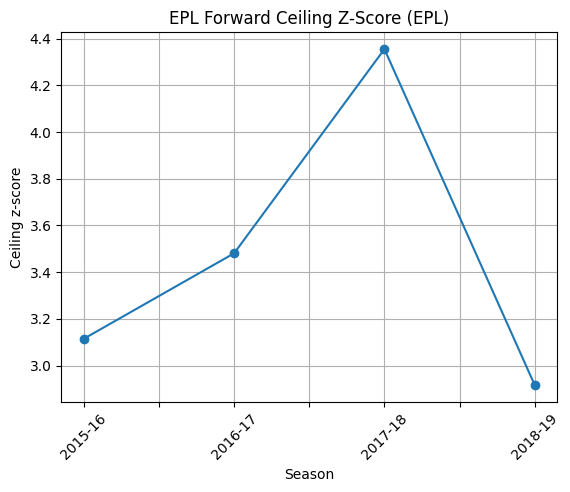

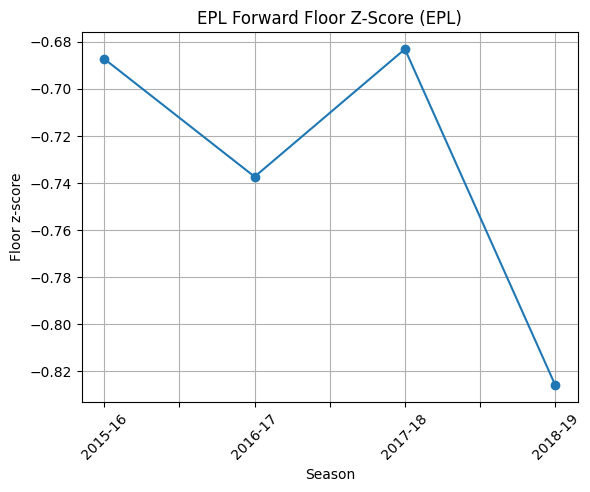

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
fw_results_epl['z_ceiling_fw'].plot(marker='o')
plt.title("EPL Forward Ceiling Z-Score (EPL)")
plt.xlabel("Season")
plt.ylabel("Ceiling z-score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure()
fw_results_epl['z_floor_fw'].plot(marker='o')
plt.title("EPL Forward Floor Z-Score (EPL)")
plt.xlabel("Season")
plt.ylabel("Floor z-score")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
fw_results_epl

,top_forward_name,top_forward_contrib,mean_contrib,std_contrib,q1_contrib,z_ceiling_fw,z_floor_fw,league
season,,,,,,,,
2015-16,Jamie Vardy,30,7.880435,7.101504,3.0,3.114772,-0.687240,EPL
2016-17,Alexis Sánchez,34,8.418605,7.349205,3.0,3.480838,-0.737305,EPL
2017-18,Mohamed Salah,42,9.151899,7.542435,4.0,4.355106,-0.683055,EPL
2018-19,Eden Hazard,31,8.400000,7.749307,2.0,2.916390,-0.825880,EPL


Phase 4

In [ ]:
# Position configuration: which stats define "impact" for each role

POSITION_METRIC_CONFIG = {
    "Forward": {
        "name": "ATT",
        "cols": ["Goals", "Assists"],
    },
    "Midfielder": {
        "name": "MID",
        "cols": ["Assists", "Big chances created", "Through balls"],
    },
    "Defender": {
        "name": "DEF",
        "cols": [
            "Tackles",
            "Interceptions",
            "Blocked shots",
            "Clearances",
            "Headed Clearance",
        ],
    },
    "Goalkeeper": {
        "name": "GK",
        "cols": ["Saves"],
    },
}


In [ ]:
import numpy as np
import pandas as pd


def position_ceiling_floor_stats(
    df_season: pd.DataFrame,
    position_label: str,
    appearances_min: int = 10,
) -> dict:
    """
    Compute ceiling and floor metrics for a given position within one league-season.

    position_label must be one of: 'Forward', 'Midfielder', 'Defender', 'Goalkeeper'
    according to the Kaggle dataset.
    """
    if position_label not in POSITION_METRIC_CONFIG:
        raise ValueError(f"Unknown position_label: {position_label}")

    cfg = POSITION_METRIC_CONFIG[position_label]
    metric_cols = cfg["cols"]

    # Filter to this position
    df_pos = df_season[df_season["Position"] == position_label].copy()

    if df_pos.empty:
        return {
            "position_label": position_label,
            "position_group": cfg["name"],
            "n_players": 0,
            "n_players_reg": 0,
            "z_ceiling": np.nan,
            "z_floor": np.nan,
        }

    # Coerce numeric for metric + appearances
    numeric_cols = list(metric_cols) + ["Appearances"]
    for col in numeric_cols:
        if col in df_pos.columns:
            df_pos[col] = pd.to_numeric(df_pos[col], errors="coerce").fillna(0)
        else:
            # Column missing: treat as 0 for now
            df_pos[col] = 0

    # Regular player filter
    df_pos = df_pos[df_pos["Appearances"] >= appearances_min].copy()

    if df_pos.empty:
        return {
            "position_label": position_label,
            "position_group": cfg["name"],
            "n_players": 0,
            "n_players_reg": 0,
            "z_ceiling": np.nan,
            "z_floor": np.nan,
        }

    # Impact metric: sum of selected columns
    df_pos["impact_metric"] = df_pos[metric_cols].sum(axis=1)

    n_all = len(df_season[df_season["Position"] == position_label])
    n_reg = len(df_pos)

    mean_val = df_pos["impact_metric"].mean()
    std_val = df_pos["impact_metric"].std(ddof=0)

    # Handle edge case: zero variance
    if std_val == 0:
        z_ceiling = np.nan
        z_floor = np.nan
        top_name = None
        top_metric = None
        q1_val = None
    else:
        # Ceiling
        top_idx = df_pos["impact_metric"].idxmax()
        top_row = df_pos.loc[top_idx]
        top_name = top_row["Name"]
        top_metric = top_row["impact_metric"]

        z_ceiling = (top_metric - mean_val) / std_val

        # Floor (Q1)
        q1_val = df_pos["impact_metric"].quantile(0.25)
        z_floor = (q1_val - mean_val) / std_val

    return {
        "position_label": position_label,      # e.g. 'Forward'
        "position_group": cfg["name"],        # e.g. 'ATT'
        "n_players": n_all,
        "n_players_reg": n_reg,
        "metric_cols": ",".join(metric_cols),
        "mean_metric": mean_val,
        "std_metric": std_val,
        "q1_metric": q1_val,
        "top_player_name": top_name,
        "top_player_metric": top_metric,
        "z_ceiling": z_ceiling,
        "z_floor": z_floor,
    }


In [ ]:
# Example: EPL 2015-16 file already loaded as df_1516
df_1516 = pd.read_csv("pl_15-16.csv")
if "Unnamed: 0" in df_1516.columns:
    df_1516 = df_1516.drop(columns=["Unnamed: 0"])

for pos in ["Forward", "Midfielder", "Defender", "Goalkeeper"]:
    stats = position_ceiling_floor_stats(df_1516, pos, appearances_min=10)
    print(pos, "→ z_ceiling:", stats["z_ceiling"], " z_floor:", stats["z_floor"])


Forward → z_ceiling: 3.114771999838297  z_floor: -0.6872396206031426
Midfielder → z_ceiling: 6.480337350239416  z_floor: -0.5483362373279507
Defender → z_ceiling: 2.601998711381233  z_floor: -0.8948361953630922
Goalkeeper → z_ceiling: 1.9780904741894136  z_floor: -0.6573299879534596


In [ ]:
all_results = []

for season, filename in season_files.items():
    print(f"Processing {season} from {filename}...")
    df_season = pd.read_csv(filename)
    if "Unnamed: 0" in df_season.columns:
        df_season = df_season.drop(columns=["Unnamed: 0"])

    for pos in ["Forward", "Midfielder", "Defender", "Goalkeeper"]:
        stats = position_ceiling_floor_stats(df_season, pos, appearances_min=10)
        stats["season"] = season
        stats["league"] = "EPL"
        all_results.append(stats)

metrics_epl = pd.DataFrame(all_results)
metrics_epl


Processing 2015-16 from pl_15-16.csv...
Processing 2016-17 from pl_16-17.csv...
Processing 2017-18 from pl_17-18.csv...
Processing 2018-19 from pl_18-19.csv...


,position_label,position_group,n_players,n_players_reg,metric_cols,mean_metric,std_metric,q1_metric,top_player_name,top_player_metric,z_ceiling,z_floor,season,league
0,Forward,ATT,168,92,"Goals,Assists",7.880435,7.101504,3.00,Jamie Vardy,30.0,3.114772,-0.687240,2015-16,EPL
1,Midfielder,MID,265,141,"Assists,Big chances created,Through balls",9.709220,12.235595,3.00,Mesut Özil,89.0,6.480337,-0.548336,2015-16,EPL
2,Defender,DEF,248,117,"Tackles,Interceptions,Blocked shots,Clearances...",247.760684,133.835315,128.00,Steve Cook,596.0,2.601999,-0.894836,2015-16,EPL
3,Goalkeeper,GK,76,27,Saves,72.962963,24.284550,57.00,Heurelho Gomes,121.0,1.978090,-0.657330,2015-16,EPL
4,Forward,ATT,177,86,"Goals,Assists",8.418605,7.349205,3.00,Alexis Sánchez,34.0,3.480838,-0.737305,2016-17,EPL
5,Midfielder,MID,298,139,"Assists,Big chances created,Through balls",9.589928,11.051100,2.00,Kevin De Bruyne,73.0,5.737897,-0.686803,2016-17,EPL
6,Defender,DEF,261,118,"Tackles,Interceptions,Blocked shots,Clearances...",250.703390,135.721881,138.25,Steve Cook,702.0,3.325157,-0.828558,2016-17,EPL
7,Goalkeeper,GK,103,27,Saves,77.222222,33.193410,53.00,Tom Heaton,141.0,1.921399,-0.729730,2016-17,EPL
8,Forward,ATT,161,79,"Goals,Assists",9.151899,7.542435,4.00,Mohamed Salah,42.0,4.355106,-0.683055,2017-18,EPL
9,Midfielder,MID,290,136,"Assists,Big chances created,Through balls",10.264706,11.746236,3.00,Kevin De Bruyne,76.0,5.596286,-0.618471,2017-18,EPL


In [ ]:
att_epl = (
    metrics_epl[metrics_epl["position_group"] == "ATT"]
    .sort_values("season")
    .set_index("season")
)

att_epl[["z_ceiling", "z_floor"]]


,z_ceiling,z_floor
season,,
2015-16,3.114772,-0.687240
2016-17,3.480838,-0.737305
2017-18,4.355106,-0.683055
2018-19,2.916390,-0.825880


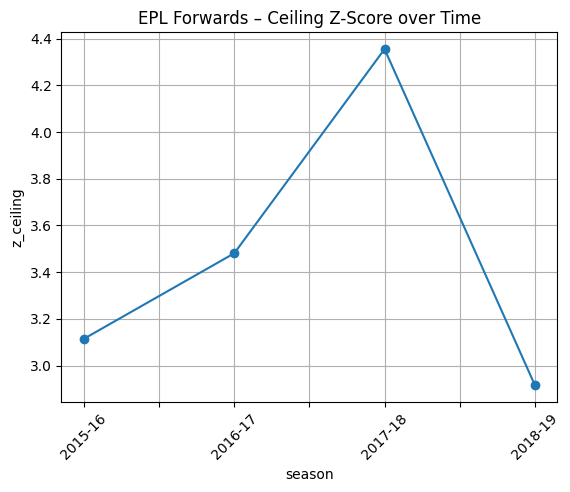

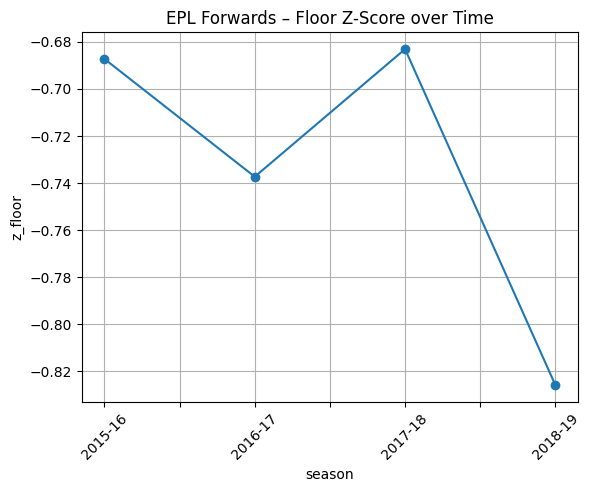

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
att_epl["z_ceiling"].plot(marker="o")
plt.title("EPL Forwards – Ceiling Z-Score over Time")
plt.ylabel("z_ceiling")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure()
att_epl["z_floor"].plot(marker="o")
plt.title("EPL Forwards – Floor Z-Score over Time")
plt.ylabel("z_floor")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
